In [23]:
import pandas as pd
import json
import codecs
import re
import gensim
import numpy as np
from os import listdir
import os
import pickle
from nltk import PorterStemmer
import random

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt


### Find optimal parameters for SVM - rbf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

stoplist = set(nltk.corpus.stopwords.words("english"))
lmtzr = WordNetLemmatizer()
porter = PorterStemmer()
bigram = None
trigram = None

In [24]:
### Load and merge bill title and bill text data ###

bill_titles = pd.read_csv('StateBills.csv')
del bill_titles['Unnamed: 0']

wd = os.getcwd()
filepath = os.path.join(wd, 'bill_texts')
states = listdir(filepath)

states.remove('.DS_Store')

colnames = ['open_bill_id', 'bill_text']
bill_text = pd.DataFrame(columns=colnames)


for state in states:  
    print(len(bill_text), "bills so far")
    text_list = []
    bill_list = listdir(os.path.join(filepath, state))
    for bill in bill_list:
        with codecs.open(filepath + "/" + state + "/" + bill, "r", encoding='utf-8', errors='ignore') as f:
            text = f.read()
            text_list.append(text)
            
    open_bill_id = pd.Series(bill_list, name = "open_bill_id")        
    text = pd.Series(text_list, name = "bill_text")
    del text_list
    
    state_bills = pd.DataFrame([open_bill_id, text])
    state_bills = state_bills.transpose()
    bill_text = bill_text.append(state_bills)
    print(len(state_bills), "bills added for", state)

0 bills so far
2223 bills added for ak
2223 bills so far
11348 bills added for al
13571 bills so far
8263 bills added for ar
21834 bills so far
11007 bills added for az
32841 bills so far
19707 bills added for ca
52548 bills so far
4336 bills added for co
56884 bills so far
12417 bills added for ct
69301 bills so far
4456 bills added for dc
73757 bills so far
2778 bills added for de
76535 bills so far
11870 bills added for fl
88405 bills so far
15512 bills added for ga
103917 bills so far
23998 bills added for hi
127915 bills so far
8393 bills added for ia
136308 bills so far
3708 bills added for id
140016 bills so far
93198 bills added for il
233214 bills so far
7348 bills added for in
240562 bills so far
4148 bills added for ks
244710 bills so far
7952 bills added for ky
252662 bills so far
16710 bills added for la
269372 bills so far
20303 bills added for ma
289675 bills so far
26053 bills added for md
315728 bills so far
8222 bills added for me
323950 bills so far
11594 bills added

In [25]:
#bill_titles = pd.read_csv('StateBills.csv', index_col=0)
# remove entries with no doc_id, since no text and cannot map to open_bill_id
bill_titles = bill_titles[bill_titles.doc_id!=" "]

doc_bill_map = pd.read_csv('doc_to_openbill_id.csv', index_col=0)
# keep only rows with bill title, drops excess open_bill_ids (otherwise no label/bill title)
bill_titles = pd.merge(left=bill_titles, right=doc_bill_map, on = 'doc_id', how='left')

print("bills with titles", len(bill_titles))
print("bills with text", len(bill_text))

# keep only rows with both bill title and bill text 
bills = pd.merge(left=bill_titles, right=bill_text, on = 'open_bill_id', how='inner')
print("bills with titles & text", len(bills))

all_bills = bills

bills with titles 814504
bills with text 787942
bills with titles & text 787842


In [26]:
len(bills[bills.guns])

7220

In [133]:
def saveDescriptives(Y_cv, Y_predict): 
    # Number of positives for training and cv
    false_pos = sum([y1 == True and y1!=y2 for (y1,y2) in zip(Y_predict, Y_cv)])
    false_neg = sum([y1 == False and y1!=y2 for (y1,y2) in zip(Y_predict, Y_cv)])
    true_pos = sum([y1 == True and y1==y2 for (y1,y2) in zip(Y_predict, Y_cv)])
    true_neg = sum([y1 == False and y1==y2 for (y1,y2) in zip(Y_predict, Y_cv)])
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
        
    print("-performance-")
    print("true positives:", true_pos, "false positives:", false_pos, "true negatives:", true_neg, "false negatives:", false_neg)
    row = [true_pos, false_pos, true_neg, false_neg, precision, recall]
    return(row)

In [28]:
def take_out_random_sample(df, size):
    subset = df.sample(size)
    sample = df.ix[subset.index]
    return (df.drop(subset.index), sample)

In [127]:
def tokenizer(bill_text):
    tokens = []
    for bill in bill_text:
        words = bill.split()
        word_list = [word.lower() for word in words]
        token_list = [porter.stem(word) for word in word_list not in stoplist]
        tokens.append(token_list)
    return(tokens)

In [128]:
bills = all_bills

In [196]:
colnames = ["issue", "model", "TP", "FP", "TN", "FN", "precision", "recall"]
t3 = pd.DataFrame(columns = colnames)

# Split into training and test data
rs = ShuffleSplit(n_splits=1, test_size=.30, random_state=20170201)
indices = rs.split(all_bills)
for train_index, test_index in indices:
    training = all_bills.iloc[train_index]
    test_set = all_bills.iloc[test_index]

print("Training:", len(training), "Test:", len(test_set))

# For issue of guns, tune labels
issue = 'guns'

# TESTING THE GUN ISSUE - RECREATE THE LABELS TO REMOVE SOME STRAY ITEMS 
newlabel = ((bills.title.str.lower().str.contains('firearm')) |
      (bills.title.str.lower().str.contains(r'\bguns?\b')) |
      (bills.title.str.lower().str.contains('ammunition')) |
      (bills.title.str.lower().str.contains('rifle')) |
      (bills.title.str.lower().str.contains('shotgun')) |
      (bills.title.str.lower().str.contains('concealed')) |
      (bills.subjects_all.str.lower().str.contains('firearms')) |
      (bills.subjects_all.str.lower().str.contains('weapons')) |
      (bills.title.str.lower().str.contains('handgun')))

training['label'] = newlabel    

print("%s issue bills" % sum(training['label']==True))
print("%s total bills" % len(training['label']))

# First save test data with original composition
new_index = rs.split(training)
for train_set, cv_set in new_index:
    X_train = training.iloc[train_set]
    cv = training.iloc[cv_set]

# Create training data with adjusted proportion
t_yes = X_train[X_train['label']==True]
t_no = X_train[X_train['label']==False] 

print("Training True", len(t_yes))
print("Training False", len(t_no))

size = 3000
prop = 0.10
t = t_yes.sample(size*prop) 
t = t.append(t_no.sample(size*(1-prop)))

Y_train = t['label'].tolist()
Y_test = cv['label'].tolist()
               
print("%s in train set" % len(Y_train))
print("%s in cv set" % len(Y_test))

# Tokenize and transform
vectorizer = CountVectorizer(min_df=10)    
transformer = TfidfTransformer(norm='l2')    

tokenize = Pipeline([
    ('vectorizer', vectorizer),
    ('transformer', transformer)
])

X_train = tokenize.fit_transform(t['bill_text'].tolist())

print("Fitting Logistic Regression")
classy_log = LogisticRegression().fit(X_train, Y_train)
#classy_svc = LinearSVC().fit(X_train, Y_train)
#classy_gnb = GaussianNB().fit(X_train.toarray(), y_train)
# commented this out to just simplify things and avoid the parameter search
# but probably time now to bring it back in

cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

print("Grid Search for Logistic:")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_log = GridSearchCV(LogisticRegression(), param_grid, cv=None)
grid_log.fit(X_train, Y_train)
log_param = grid_log.best_params_
classy_log = LogisticRegression(C = log_param['C']).fit(X_train, Y_train)
print("The best parameters are %s with a score of %0.2f \n"
  % (grid_log.best_params_, grid_log.best_score_))

print("Grid Search for SVM - Gaussian:")
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
grid_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=None)
grid_svm.fit(X_train, Y_train)
svm_param = grid_svm.best_params_
print("The best parameters are %s with a score of %0.2f \n"
  % (grid_svm.best_params_, grid_svm.best_score_))
classy_svm = SVC(gamma=svm_param['gamma'], C = svm_param['C']).fit(X_train, Y_train)

print("Predicting on test set")
X_tokens = tokenize.transform(cv['bill_text'].tolist())
Y_pred_svm = classy_svm.predict(X_tokens)
Y_score = classy_svm.decision_function(X_tokens)
Y_pred_log = classy_log.predict(X_tokens)
Y_prob = classy_log.predict_proba(X_tokens)

perform_log = saveDescriptives(Y_test, Y_pred_log)
perform_svm = saveDescriptives(Y_test, Y_pred_svm)

m1 = pd.DataFrame([issue, "Logistic"] + perform_log, index = colnames).transpose()
m2 = pd.DataFrame([issue, "SVC (gaussian)"] + perform_svm, index = colnames).transpose()

t3 = t3.append(m1)
t3 = t3.append(m2)

Training: 220595 Test: 94542


/Users/kelly/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


525 issue bills
220595 total bills
Training True 361
Training False 30600
3000 in train set
66179 in cv set
Fitting Logistic Regression
Grid Search for Logistic:
The best parameters are {'C': 1000} with a score of 0.97 

Grid Search for SVM - Gaussian:


KeyboardInterrupt: 

In [193]:
for train_set, cv_set in new_index:
    X_train = training.loc[train_set,:]
    cv = training.loc[cv_set,:]
    
cv.head()

,doc_id,bill_name,state,title,subjects_all,abortion,education,energy,environment,guns,health,transport,unionlabor,open_bill_id,bill_text,label
87364,FLD00031701,FL_2015_SB 76,FL,RELIEF OF MELVIN AND ALMA COLINDRES BY THE CIT...,[],False,False,False,False,False,False,False,False,FLB00008908,\n\r\n Florida Senate - 2015 ...,NaN
193252,ILD00084658,,IL,MEMORIAL - JEFFERY PORTER,[],False,False,False,False,False,False,False,False,ILB00042641,\n\n\n\n\n\n\n\n\nIllinois General Assembly - ...,NaN
500714,NYD00149516,NY_2013-2014_A 5402,NY,REQUIRES APPROVAL OF THE GOVERNING BODY OF A C...,['GENERAL CITY LAW'],False,False,False,False,False,False,False,False,NYB00039492,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nNew York State A...,False
259530,LAD00035583,LA_2014_HB 501,LA,VOTING/REGISTRATION:Â Â PROVIDES FOR VOTER REG...,[],False,False,False,False,False,False,False,False,LAB00011196,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,NaN
197486,ILD00076243,,IL,MEMORIAL-BRENT STAYTON,[],False,False,False,False,False,False,False,False,ILB00038114,\n\n\n\n\n\n\n\n\nIllinois General Assembly - ...,NaN


In [130]:
probs = Y_prob[:,1]
scores = Y_score
#print(log_probs.tolist())
features = vectorizer.get_feature_names()
log_coefs = classy_log.coef_
svm_coefs = classy_svm.coef_

In [131]:
coefs = pd.DataFrame({'features': features, 'log': log_coefs.tolist().pop(0), 'svc': svc_coefs.tolist().pop(0), 'svm': svm_coefs.tolist().pop(0)})
print("Top words in log model \n", coefs.sort_values('log')[0:40])
print()
print("Top words in svc model \n", coefs.sort_values('svc')[0:40])
print()
print("Top words in svm model \n", coefs.sort_values('svm')[0:40])

,features,log,svm
0,00,0.590199,0.532705
1,000,-0.536057,-0.108290
2,00000,-0.106719,-0.045798
3,000000,-0.009350,-0.006083
4,0000ff,0.122377,0.019946


In [132]:
# Create empty performance table 
colnames = ["issue", "model", "TP", "FP", "TN", "FN", "precision", "recall"]
t4 = pd.DataFrame(columns = colnames)

# Split into test and training set
rs = ShuffleSplit(n_splits=1, test_size=.30, random_state=20170201)
indices = rs.split(all_bills)
training = all_bills[indices.train[0]]
test = all_bills[indices.test[0]]




print("%s in train set" % len(Y_train))
print("%s in test set" % len(y_test))


print("Fitting word2vec and transforming")
model = gensim.models.Word2Vec(tokenizer(X_text), size=100, min_count = 10)
w2v = dict(zip(model.index2word, model.syn0))
X_train = TfidfEmbeddingVectorizer(w2v, Y_train).tolist()

model.save('/word2vec_model')
#model = gensim.models.Word2Vec.load('/word2vec_model')

print("Training set created, fitting models")

classy_svc = LinearSVC().fit(X_train, Y_train)
classy_log = LogisticRegression().fit(X_train, Y_train)
#classy_gnb = GaussianNB().fit(X_train.toarray(), y_train)
# commented this out to just simplify things and avoid the parameter search
# but probably time now to bring it back in

print("Performing grid search for SVM - gaussian")
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cross_val)
grid.fit(X_train, Y_train)
param = grid.best_params_
print("The best parameters are %s with a score of %0.2f"
  % (grid.best_params_, grid.best_score_))
classy_svm = SVC(gamma=param['gamma'], C = param['C']).fit(X_train, Y_train)

print("Models fit, creating test matrix")
X_test = tokenize.transform(test1['bill_text'].tolist())
Y_test = test1[issue].tolist()

print("Test matrix created, applying model\n")
Y_pred_svc = classy_svc.predict(X_test)
Y_pred_log = classy_log.predict(X_test)
Y_prob_log = classy_log.predict_proba(X_test)
#    Y2 = classy_svm.predict(X_cv)
Y_pred_svm = classy_svc.predict(X_test)

perform_svc = saveDescriptives(Y_test, Y_pred_svc)
perform_log = saveDescriptives(Y_test, Y_pred_log)
perform_svm = saveDescriptives(Y_test, Y_pred_svm)


m1 = pd.DataFrame([issue, "SVC (linear)"] + perform_svc, index = colnames).transpose()
m2 = pd.DataFrame([issue, "Logistic"] + perform_log, index = colnames).transpose()
m3 = pd.DataFrame([issue, "SVC (gaussian)"] + perform_svm, index = colnames).transpose()

t4 = t4.append(m1)
t4 = t4.append(m2)
t4 = t4.append(m3)

Top words in log model 
             features       log       svm
2573             and -1.556047 -0.352815
13755        whereas -1.511321 -0.215298
6466             for -1.362886 -0.587248
12787            the -0.966305  0.084370
7042          health -0.956036 -0.655205
3849           child -0.928619 -0.469921
11815        service -0.915945 -0.572366
12666            tax -0.912884 -0.315133
3643            care -0.909887 -0.239823
7683       insurance -0.807250 -0.446561
2551          amount -0.744199 -0.381786
7316        illinois -0.736186 -0.408727
5843          entity -0.670494 -0.624733
5487          driver -0.668700 -0.703406
11817       services -0.664105  0.073486
8906     mississippi -0.651836 -0.424797
4101    commissioner -0.647915 -0.596209
10457        program -0.643370 -0.083753
3326           board -0.632992 -0.057029
7870             its -0.622840 -0.183710
7021          hawaii -0.617230 -0.175241
7447          income -0.608919 -0.077591
10072           plan -0.606141 -

In [145]:
len(training)

220595

In [119]:
test1['probs'] = probs 

In [122]:
## Examine the mistakes
# False positive
fp_titles = test1[Y_pred_log & ~test1.guns]['title'].tolist()
fp_probs = test1[Y_pred_log & ~test1.guns]['probs'].tolist()

fp = pd.DataFrame({'titles': fp_titles, 'probs': fp_probs})
fp

,probs,titles
0,0.818157,ESTABLISHES ARSON INVESTIGATION UNIT IN DIVISI...
1,0.968702,ENACTING THE KANSAS PROTECTION AGAINST TERRORI...
2,0.996321,FOID&CRIM CD-PRIVATE&GANG
3,0.657883,REQUIRE BACKGROUND CHECKS AND OTHER REQUIREMEN...
4,0.750775,CRIMINAL LAW-TECH
5,0.720328,CRIMINAL LAW-TECH
6,0.629500,CRIM CD-AGG BATTERY


In [124]:
#False negatives

fn_titles = test1[~Y_pred_svc & test1.guns]['title'].tolist()
fn_probs = test1[~Y_pred_svc & test1.guns]['probs'].tolist()

fn = pd.DataFrame({'titles': fn_titles, 'probs': fn_probs})
fn

,probs,titles
0,0.122024,AN ACT RELATIVE TO FIREARM SAFETY TRAINING OF ...
1,0.257156,ESTABLISHES THE MISSOURI FIREARMS INDUSTRY NON...
2,0.318399,HOSP SECURITY CARRY GUNS
3,0.135527,UNSAFE HANDGUNS: SINGLE-SHOT PISTOLS.
4,0.120468,RELATING TO: MAKING A FALSE THREAT TO USE A FI...
5,0.089289,AN ACT TO ESTABLISH A NATIONAL RIFLE ASSOCIATI...
6,0.098093,DPH-FIREARM INJURIES-TECH
7,0.075485,AUXILIARY POLICE OFFICERS; FIREARMS TRAINING S...
8,0.096181,WEAPONS ON PUBLIC TRANSPORTATION
9,0.118181,RELATES TO THE MINIMUM DISTANCE A FIREARM MAY ...


In [ ]:

################################### OLD TRAINING/TESTING CODE #####################################


In [4]:
### Split into test, cv, and training ###
# Keep only union of both datasets (i.e. no bill titles without bill text, and no bill text without title/labels)

random.seed(20170106)

df = bills
print("Labeled Bills:",len(df))
nprop = round(len(df)*0.20)

subset1 = df.sample(nprop)
test = df.ix[subset1.index]
df = df.drop(subset1.index)

subset2 = df.sample(nprop)
cv = df.ix[subset2.index]
df = df.drop(subset2.index)

training = df

print("Test Set:", len(test), "CV Set:", len(cv), "Training Set:", len(df))
### Check data
#print(training.sort_values('doc_id').head()) 
#print(test.sort_values('doc_id').head())
#print(cv.sort_values('doc_id').head()) 

Labeled Bills: 787842
Test Set: 157568 CV Set: 157568 Training Set: 472706


In [6]:
### Training Classifiers ###

#training_selected = training[(training.state=='NM')|(training.state=='OH')|(training.state=='MS')|(training.state=='OK')|(training.state=='VA')]
#cv_selected = cv[(cv.state=='NM')|(cv.state=='OH')|(cv.state=='MS')|(cv.state=='OK')|(cv.state=='VA')]
#print(len(training_selected), len(cv_selected))

# abortion true: 1062 
# Training set size
size = 5000

# List of issues
issues = ['abortion', 'education', 'energy', 'environment', 'guns', 'health', 'transport', 'unionlabor']

# Table storing model descriptives
colnames = ["issue", "prop", "cv-error", "model", "TP", "FP", "TN", "FN"]

props = [0.05, 0.10, 0.15, 0.20]

issueList = []

for issue in issues:

    t3 = pd.DataFrame(columns = colnames)
    
    C_list = []
    gamma_list = []
    
    for prop in props:
        print(issue,":", prop)
        
        # Subset training data
        t_yes = training[training[issue]==True]
        t_no = training[training[issue]==False] 
        
        print("TRUE", len(t_yes))
        print("FALSE", len(t_no))

        t = t_yes.sample(size*prop) 
        t = t.append(t_no.sample(size*(1-prop)))

        y_train = t[issue].tolist()
        full_text = t['bill_text'].tolist()

        vectorizer = CountVectorizer(min_df=10, stop_words = stoplist)
        transformer = TfidfTransformer(norm='l1')    

        tokenize = Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer)
        ])

        X_train = tokenize.fit_transform(full_text)

        subset = t.sample(1000)
        X_tokens = subset['bill_text']
        X = tokenize.transform(X_tokens)
        y = subset[issue].tolist()

        C_range = np.logspace(-2, 10, 13)
        gamma_range = np.logspace(-9, 3, 13)
        param_grid = dict(gamma=gamma_range, C=C_range)
        cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cross_val)
        grid.fit(X, y)
        param = grid.best_params_
        print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
        
        issue_C = param['C']
        C_list.append(issue_C)
        issue_gamma = param['gamma']
        gamma_list.append(issue_gamma)
        
        # Tokenize cross-validation data 
        # Set cv size 
        c = cv.sample(size)
        y_cv = c[issue].tolist()
        cv_text = c['bill_text'].tolist()
        X_cv = tokenize.transform(cv_text)

        # Fit models on training
        classy_svc = LinearSVC().fit(X_train, y_train)
        classy_log = LogisticRegression().fit(X_train, y_train)
        classy_gnb = GaussianNB().fit(X_train.toarray(), y_train)
        classy_svm = SVC(gamma=issue_gamma, C = issue_C).fit(X_train, y_train)

        # Predict on cross-validation
        Y1 = classy_svc.predict(X_cv)
        e1 = (Y1!=y_cv).sum()/len(y_cv)

        Y2 = classy_svm.predict(X_cv)
        e2 = (Y2!=y_cv).sum()/len(y_cv)

        Y3 = classy_log.predict(X_cv)
        #p3 = classy_log.predict_proba(X_cv)
        e3 = (Y3!=y_cv).sum()/len(y_cv)

        Y4 = classy_gnb.predict(X_cv.toarray())
        #p4 = classy_gnb.predict_proba(X_cv.toarray())
        e4 = (Y4!=y_cv).sum()/len(y_cv)

        # Number of positives for training and cv
        print("TRAINING SIZE", size)
        print("TRAINING TRUE:", sum(y_train), "CV TRUE:", sum(y_cv))
        print("M1: SVC (LINEAR) ERROR", e1)
        perform1 = saveDescriptives(y_cv, Y1)
        print("M2: SVC (GAUSSIAN) ERROR", e2)
        perform2 = saveDescriptives(y_cv, Y2)
        print("M3: LOGISTIC ERROR", e3)
        perform3 = saveDescriptives(y_cv, Y3)
        print("M4: NAIVE BAYES ERROR", e4)
        perform4 = saveDescriptives(y_cv, Y4)

        m1 = pd.DataFrame([issue, prop, e1, "SVC (linear)"] + perform1, index = colnames).transpose()
        m2 = pd.DataFrame([issue, prop, e2, "SVC (rbf)"] + perform2, index = colnames).transpose()
        m3 = pd.DataFrame([issue, prop, e3, "Logistic"] + perform3, index = colnames).transpose()
        m4 = pd.DataFrame([issue, prop, e4, "NaiveBayes"] + perform4, index = colnames).transpose()

        t3 = t3.append(m1)
        t3 = t3.append(m2)
        t3 = t3.append(m3)
        t3 = t3.append(m4)

    issueList.append(t3)

abortion : 0.05
TRUE 1092
FALSE 471614
The best parameters are {'C': 100.0, 'gamma': 1.0} with a score of 0.99
TRAINING SIZE 5000
TRAINING TRUE: 250 CV TRUE: 11
M1: SVC (LINEAR) ERROR 0.002
-performance-
true positives: 1 false positives: 0 true negatives: 4989 false negatives: 10
M2: SVC (GAUSSIAN) ERROR 0.0026
-performance-
true positives: 10 false positives: 12 true negatives: 4977 false negatives: 1
M3: LOGISTIC ERROR 0.0022
-performance-
true positives: 0 false positives: 0 true negatives: 4989 false negatives: 11
M4: NAIVE BAYES ERROR 0.0106
-performance-
true positives: 7 false positives: 49 true negatives: 4940 false negatives: 4
abortion : 0.1
TRUE 1092
FALSE 471614
The best parameters are {'C': 1000.0, 'gamma': 0.10000000000000001} with a score of 0.97
TRAINING SIZE 5000
TRAINING TRUE: 500 CV TRUE: 8
M1: SVC (LINEAR) ERROR 0.0006
-performance-
true positives: 5 false positives: 0 true negatives: 4992 false negatives: 3
M2: SVC (GAUSSIAN) ERROR 0.001
-performance-
true positiv

In [34]:
## See most important words - not very helpful
keywords = pd.DataFrame([t for t in zip(vectorizer.get_feature_names(),
                                        transformer.idf_)])
keywords.columns=('word','val')
keywords.sort('val', ascending=False)

/home/mvpolyakov/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,word,val
5062,pitt,7.625272
793,blueprint,7.625272
5886,ron,7.625272
6769,theatric,7.625272
1523,contrast,7.625272
1935,dinowitz,7.625272
4117,malon,7.625272
1937,diploma_ged,7.625272
4119,malt_beverag,7.625272
790,bloom,7.625272


In [ ]:
def createTable(dfList, fileName):
    colnames = ['issue', 'prop', 'cv-error', 'model', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall', 'f1']
    table = pd.DataFrame(columns=colnames)
    for df in dfList: 
        # Store precision and recall in table
        df['precision'] = (df['TP'].astype('float64')/(df['TP'] + df['FP']).astype('float64'))
        df['recall'] = (df['TP'].astype('float64')/(df['TP'] + df['FN']).astype('float64'))
        df['f1'] = 2*(df['precision']*df['recall'])/(df['precision']+df['recall'])
        table = table.append(df)

    # Write to csv file
    table.to_csv(fileName)
    return(table)

In [15]:
def plot_precision_recall(table, issue_list, file):    
    plt.figure()
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.xlim(0.00, 1.01)
    plt.ylim(0.00, 1.01)
    plt.plot(table.precision[(table.model=="SVC (linear)")], table.recall[(table.model=="SVC (linear)")], 'o', color = "r", label = "svc - linear")
    plt.plot(table.precision[(table.model=="SVC (rbf)")], table.recall[(table.model=="SVC (rbf)")], 'o', color = "m", label = "svc - gaussian")
    plt.plot(table.precision[(table.model=="Logistic")], table.recall[(table.model=="Logistic")], 'o', color = "b", label = "logistic")
    plt.plot(table.precision[(table.model=="NaiveBayes")], table.recall[(table.model=="NaiveBayes")], 'o', color = "g", label = "naive bayes")

    plt.legend(loc="lower left")
    plt.savefig("precision-recall-" + file, format='png')
    
    for issue in issue_list:
        t = table[table.issue==issue]
        plt.figure()
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.xlim(0.00, 1.01)
        plt.ylim(0.00, 1.01)
        plt.plot(t.precision[(t.model=="SVC (linear)")], t.recall[(t.model=="SVC (linear)")], 'o', color = "r", label = "svc - linear")
        plt.plot(t.precision[(t.model=="SVC (rbf)")], t.recall[(t.model=="SVC (rbf)")], 'o', color = "m", label = "svc - gaussian")
        plt.plot(t.precision[(t.model=="Logistic")], t.recall[(t.model=="Logistic")], 'o', color = "b", label = "logistic")
        plt.plot(t.precision[(t.model=="NaiveBayes")], t.recall[(t.model=="NaiveBayes")], 'o', color = "g", label = "naive bayes")

        plt.legend(loc="lower left")
        plt.savefig("precision-recall-" + issue + file, format='png')
    
    plt.show()

In [9]:
def plot_f1(table, issue_list, file):   
    for issue in issue_list:
        t = table[table.issue==issue]
        plt.figure()
        plt.xlabel("Proportion")
        plt.ylabel("F1")
        plt.xlim(0.00, 0.25)
        plt.ylim(0.00, 1.01)
        plt.plot(t.prop[(t.model=="SVC (linear)")], t.f1[(t.model=="SVC (linear)")], 'o-', color = "r", label = "svc - linear")
        plt.plot(t.prop[(t.model=="SVC (rbf)")], t.f1[(t.model=="SVC (rbf)")], 'o-', color = "m", label = "svc - gaussian")
        plt.plot(t.prop[(t.model=="Logistic")], t.f1[(t.model=="Logistic")], 'o-', color = "b", label = "logistic")
        plt.plot(t.prop[(t.model=="NaiveBayes")], t.f1[(t.model=="NaiveBayes")], 'o-', color = "g", label = "naive bayes")

        plt.legend(loc="best")
        plt.savefig("f1-" + issue + file, format='png')
        plt.show()

In [18]:
t1 = createTable(issueList, "models-l1.csv")
t1[1:100]

,issue,prop,cv-error,model,TP,FP,TN,FN,precision,recall,f1
0,abortion,0.05,0.0026,SVC (rbf),10,12,4977,1,0.454545,0.909091,0.606061
0,abortion,0.05,0.0022,Logistic,0,0,4989,11,NaN,0.000000,NaN
0,abortion,0.05,0.0106,NaiveBayes,7,49,4940,4,0.125000,0.636364,0.208955
0,abortion,0.1,0.0006,SVC (linear),5,0,4992,3,1.000000,0.625000,0.769231
0,abortion,0.1,0.001,SVC (rbf),8,5,4987,0,0.615385,1.000000,0.761905
0,abortion,0.1,0.0016,Logistic,0,0,4992,8,NaN,0.000000,NaN
0,abortion,0.1,0.015,NaiveBayes,6,73,4919,2,0.075949,0.750000,0.137931
0,abortion,0.15,0.001,SVC (linear),8,1,4987,4,0.888889,0.666667,0.761905
0,abortion,0.15,0.0032,SVC (rbf),11,15,4973,1,0.423077,0.916667,0.578947
0,abortion,0.15,0.0024,Logistic,0,0,4988,12,NaN,0.000000,NaN


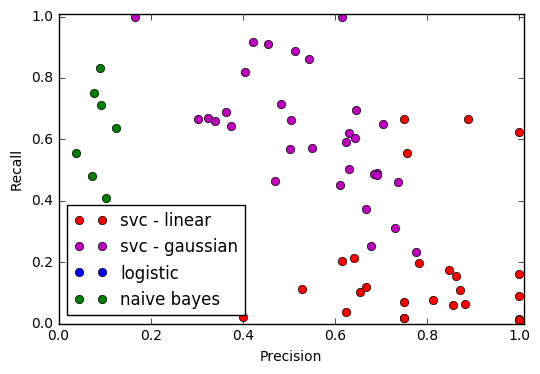

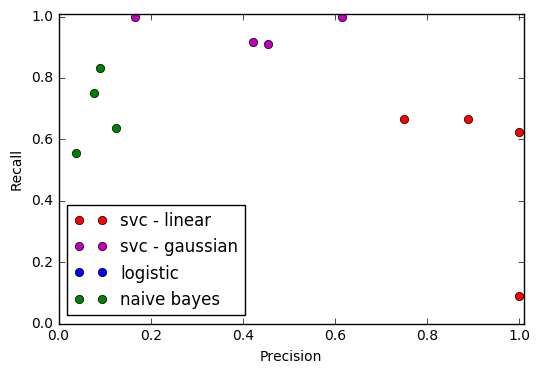

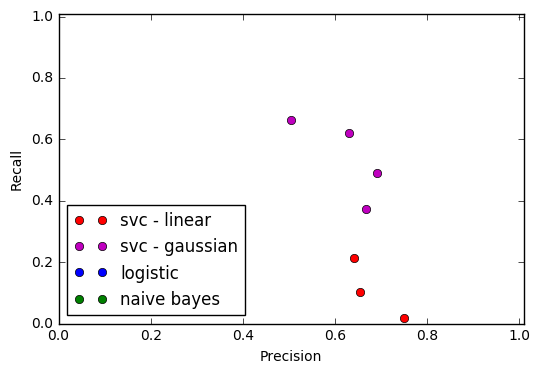

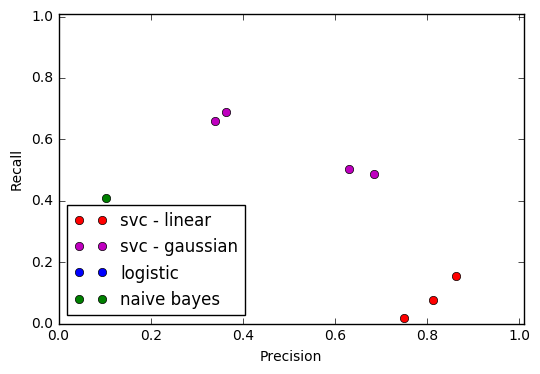

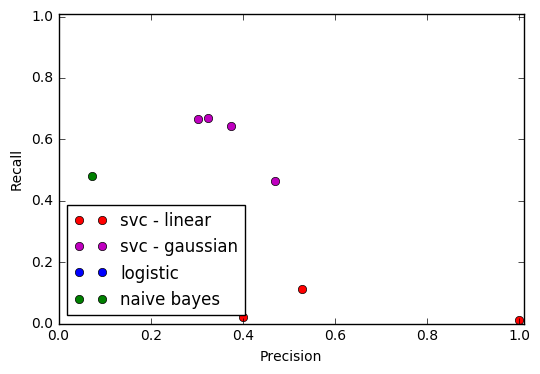

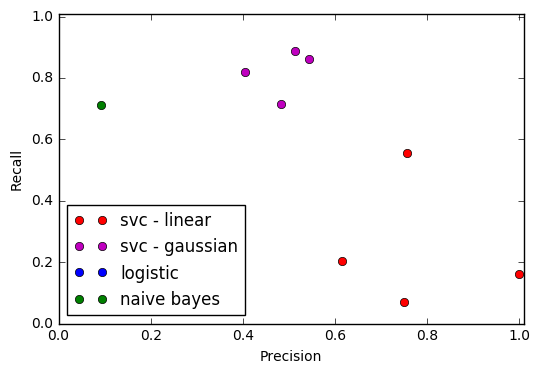

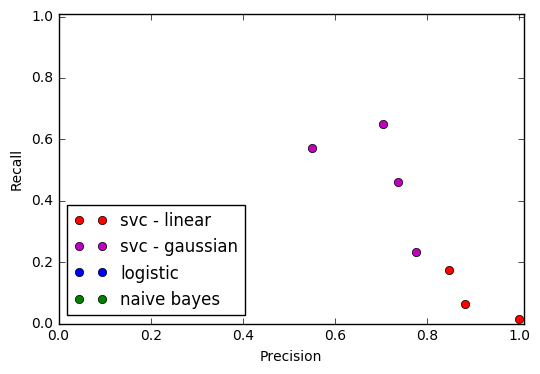

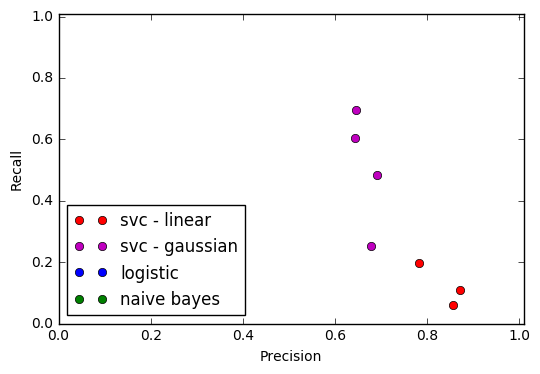

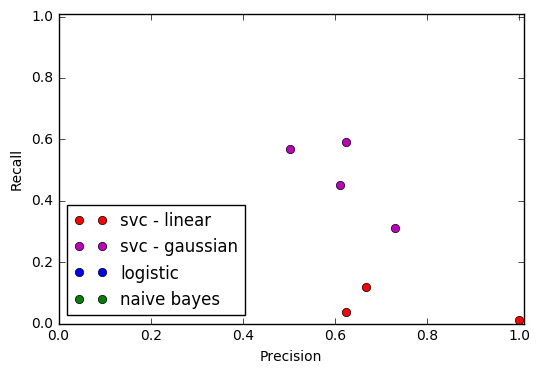

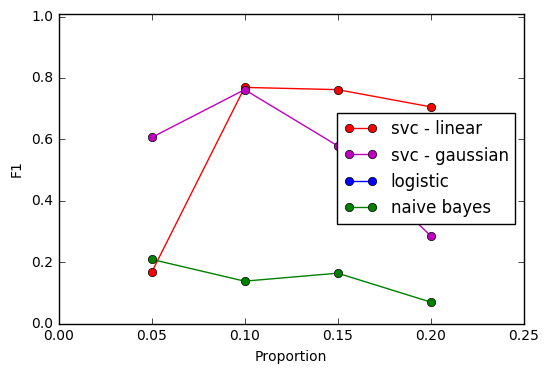

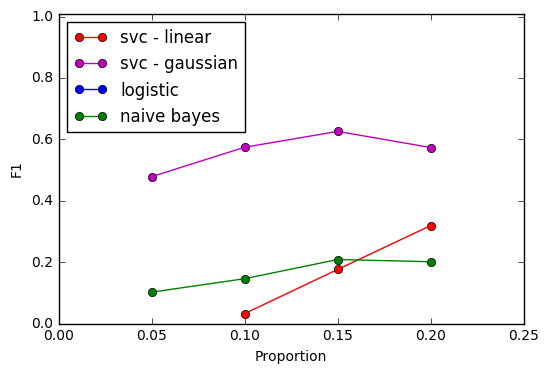

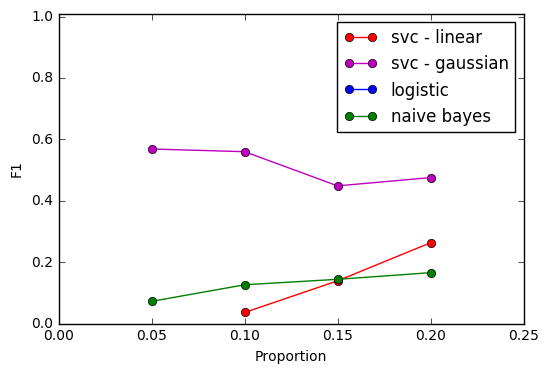

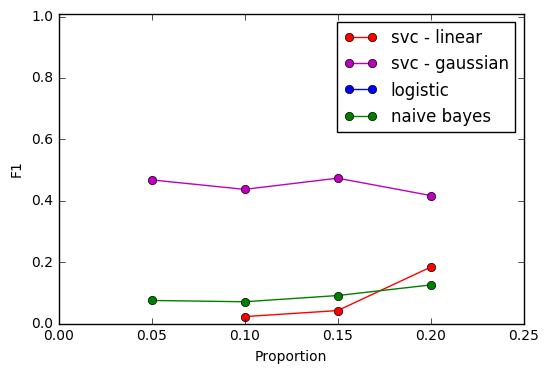

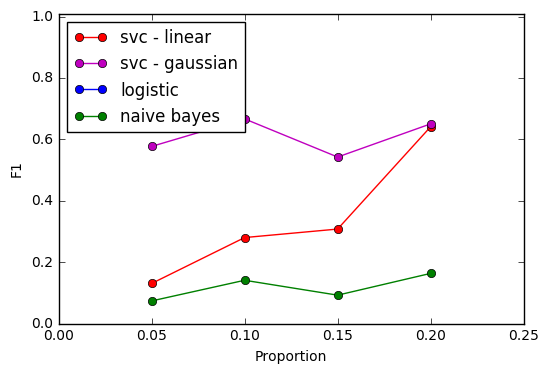

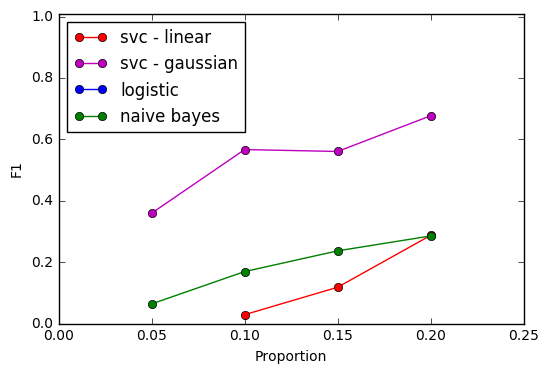

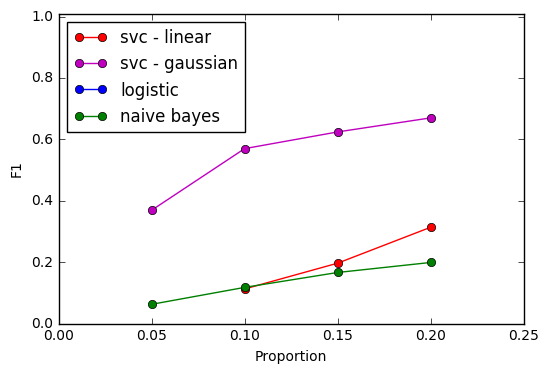

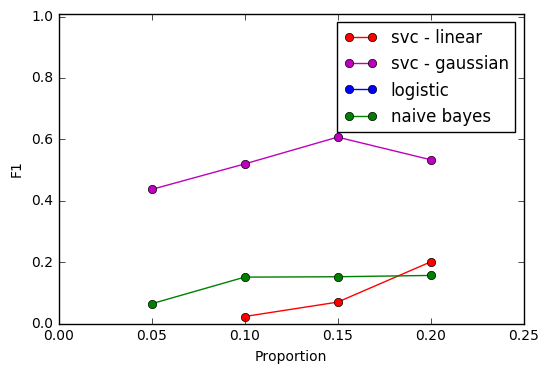

In [16]:
plot_precision_recall(t1, issues, "prop-l1.png")
plot_f1(t1, issues, "prop-l1.png")

In [12]:
def best_performers(performance):
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    df3 = pd.DataFrame()

    for issue in issues:
        maxF1 = max(performance.f1[performance.issue==issue])
        maxPrecision = max(performance.precision[performance.issue==issue])
        maxRecall = max(performance.recall[performance.issue==issue])
        #print(issue)
        #print(maxF1, maxPrecision, maxRecall)

        df1=df1.append(performance[(performance.f1==maxF1) & (performance.issue==issue)])
        df2=df2.append(performance[(performance.precision==maxPrecision) & (performance.issue==issue)])
        df3=df3.append(performance[(performance.recall==maxRecall) & (performance.issue==issue)])

        df1['best'] = 'F1'
        df2['best'] = 'Precision'
        df3['best'] = 'Recall'

    df = df.append(df1)
    df = df.append(df2) 
    df = df.append(df3)    
    return(df)

In [13]:
col1 = ['best', 'model', 'issue', 'prop', 'TP', 'FP', 'TN', 'FN', 'cv-error', 'precision', 'recall', 'f1']
t1_best = best_performers(t1)
t1_best = t1_best[col1]
t1_best.to_csv("best-prop-models-l1.csv", index=False)

t1_best

,best,model,issue,prop,TP,FP,TN,FN,cv-error,precision,recall,f1
0,F1,SVC (linear),abortion,0.1,5,0,4992,3,0.0006,1.000000,0.625000,0.769231
0,F1,SVC (rbf),guns,0.1,37,31,4926,6,0.0074,0.544118,0.860465,0.666667
0,Precision,SVC (linear),abortion,0.05,1,0,4989,10,0.002,1.000000,0.090909,0.166667
0,Precision,SVC (linear),abortion,0.1,5,0,4992,3,0.0006,1.000000,0.625000,0.769231
0,Precision,SVC (linear),guns,0.1,7,0,4957,36,0.0072,1.000000,0.162791,0.280000
0,Recall,SVC (rbf),abortion,0.1,8,5,4987,0,0.001,0.615385,1.000000,0.761905
0,Recall,SVC (rbf),abortion,0.2,9,45,4946,0,0.009,0.166667,1.000000,0.285714
0,Recall,SVC (rbf),education,0.2,256,251,4363,130,0.0762,0.504931,0.663212,0.573348
0,Recall,SVC (rbf),energy,0.2,111,195,4644,50,0.049,0.362745,0.689441,0.475375
0,Recall,SVC (rbf),environment,0.1,59,123,4789,29,0.0304,0.324176,0.670455,0.437037


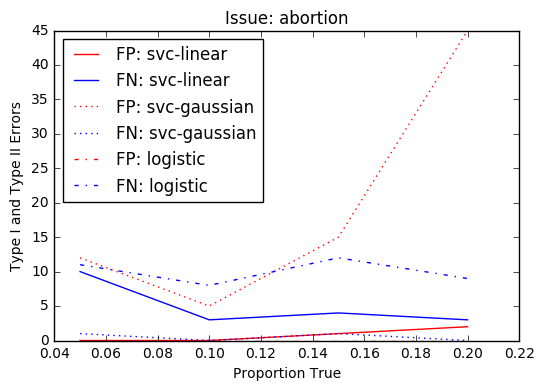

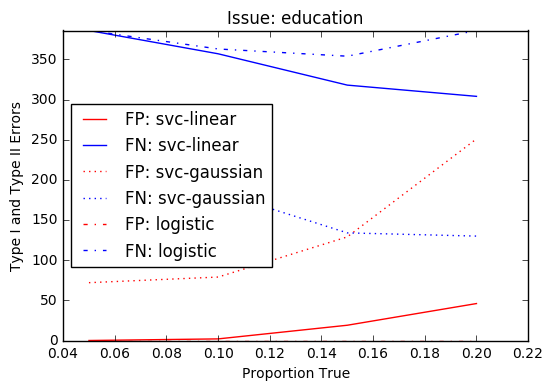

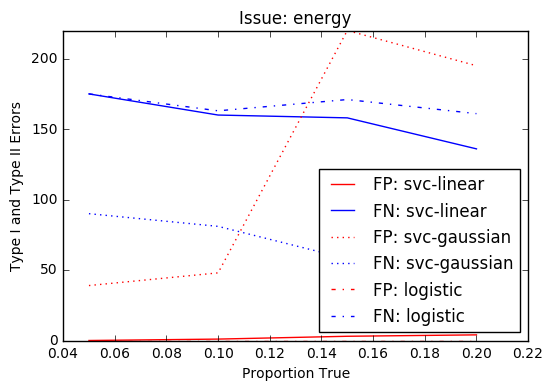

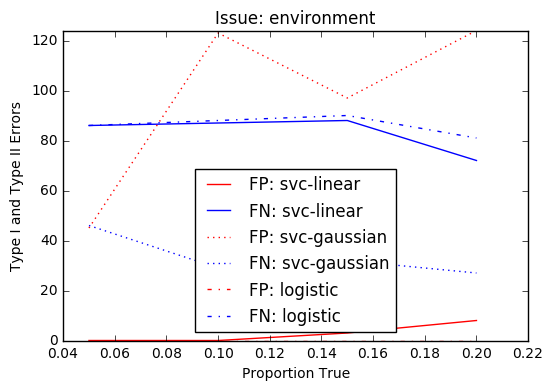

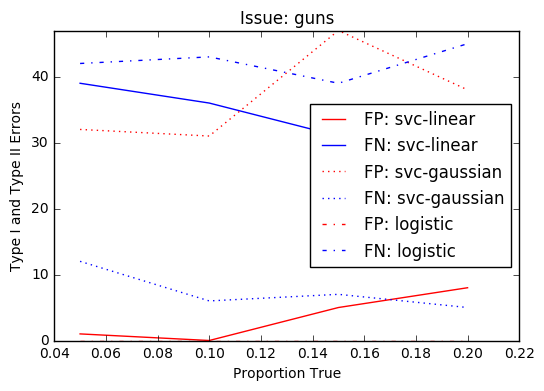

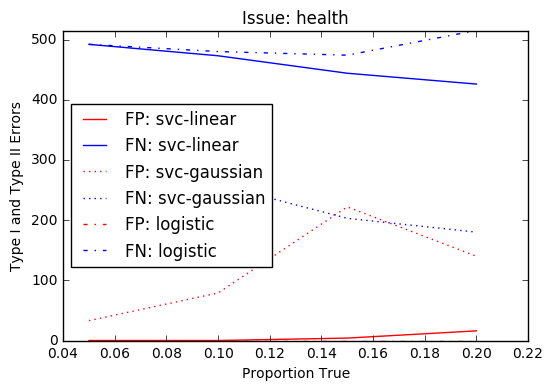

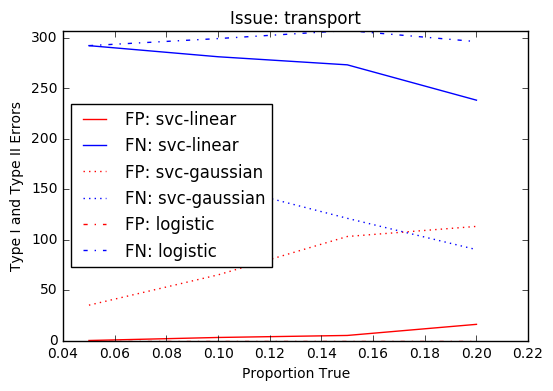

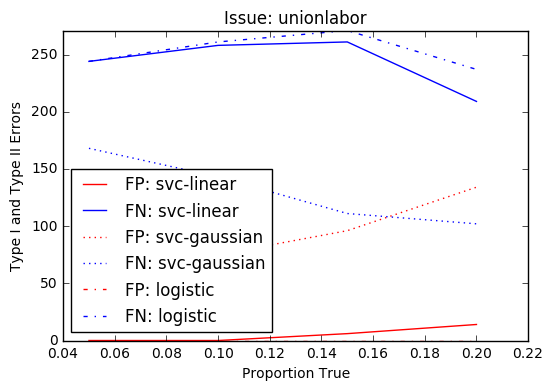

In [14]:
### Plot error rates ###

for issue in issues:
    plt.figure()
    plt.title('Issue: ' + issue)
    
    s = t1[(t1.issue==issue) & (t1.model!="NaiveBayes")]
    plt.xlabel("Proportion True")
    plt.ylabel("Type I and Type II Errors")
    plt.ylim(0, max(max(s.FP), max(s.FN)))
    
    plt.plot(s.prop[s.model=="SVC (linear)"], s.FP[s.model=="SVC (linear)"], '-', color = "r", label = "FP: svc-linear")
    plt.plot(s.prop[s.model=="SVC (linear)"], s.FN[s.model=="SVC (linear)"], '-', color = "b", label = "FN: svc-linear")
    plt.plot(s.prop[s.model=="SVC (rbf)"], s.FP[s.model=="SVC (rbf)"], ':', color = "r", label = "FP: svc-gaussian")
    plt.plot(s.prop[s.model=="SVC (rbf)"], s.FN[s.model=="SVC (rbf)"], ':', color = "b", label = "FN: svc-gaussian")
    plt.plot(s.prop[s.model=="Logistic"], s.FP[s.model=="Logistic"], '-.', color = "r", label = "FP: logistic")
    plt.plot(s.prop[s.model=="Logistic"], s.FN[s.model=="Logistic"], '-.', color = "b", label = "FN: logistic")
    #plt.plot(s.prop[s.model=="NaiveBayes"], s.FP[s.model=="NaiveBayes"], ':', color = "r", label = "FP: naive bayes")
    #plt.plot(s.prop[s.model=="NaiveBayes"], s.FN[s.model=="NaiveBayes"], ':', color = "b", label = "FN: naive bayes")
    
    plt.legend(loc="best")
    plt.savefig('l1-prop-error-rate-' + issue + '.png', format='png')
    plt.show()

In [20]:
'''def tokens_from_text(text):
    def stem(word):
        # Some non-word strings ('aed') that happen to be in the text can trip up the stemmer
        try:
            return porter.stem(word)
        except:
            return word
            
    pre_tok = gensim.utils.tokenize(text, lowercase=True, deacc=True, errors="ignore")
    tokens = [stem(word) for word in pre_tok if word not in stoplist]
    if bigram and trigram:
        return trigram[bigram[tokens]]    
    else:
        return tokens'''

In [6]:
'''def generate_ngram_models(bills):
    global bigram
    global trigram

    by_state = {}
    
    bg = None
    tg = None
    
    print("generating bigram model")
    for state in bills.state.unique():
        print(state)
        # create token array by state 
        tokens = []
        for t in bills.ix[bills.state==state, 'bill_text']:
            tokens.append(tokens_from_text(t))
        
        by_state[state] = tokens
        if bg:
            bg.add_vocab(tokens)
        else:
            bg = gensim.models.Phrases(tokens, threshold=30)  # 60 is good if by itself - look at a small sample!        
    
    # separate local and global variables in case fails half way for some reason
    bigram = bg
    
    print("generating trigram model")
    for state in bills.state.unique():
        print(state)
        tokens = []

        if tg:
            tg.add_vocab(bigram[ by_state[state] ])
        else:
            tg = gensim.models.Phrases(bigram[by_state[state]], threshold=30) # with trigrams, 30 and 30 work well - CHECK WHEN ADDING NEW TEXT
    trigram = tg
                
bi_model_name = '/home/mvpolyakov/datasci/leg_topic_model/bigram.model'
tri_model_name = '/home/mvpolyakov/datasci/leg_topic_model/trigram.model'
try:
    bigram = pickle.load(open(bi_model_name, 'rb'))
    trigram = pickle.load(open(tri_model_name, 'rb'))
except:    
    generate_ngram_models(bills)
    pickle.dump(bigram, open(bi_model_name, 'wb'))
    pickle.dump(trigram, open(tri_model_name, 'wb'))'''

'def generate_ngram_models(bills):\n    global bigram\n    global trigram\n\n    by_state = {}\n    \n    bg = None\n    tg = None\n    \n    print("generating bigram model")\n    for state in bills.state.unique():\n        print(state)\n        # create token array by state \n        tokens = []\n        for t in bills.ix[bills.state==state, \'bill_text\']:\n            tokens.append(tokens_from_text(t))\n        \n        by_state[state] = tokens\n        if bg:\n            bg.add_vocab(tokens)\n        else:\n            bg = gensim.models.Phrases(tokens, threshold=30)  # 60 is good if by itself - look at a small sample!        \n    \n    # separate local and global variables in case fails half way for some reason\n    bigram = bg\n    \n    print("generating trigram model")\n    for state in bills.state.unique():\n        print(state)\n        tokens = []\n\n        if tg:\n            tg.add_vocab(bigram[ by_state[state] ])\n        else:\n            tg = gensim.models.Phrases(